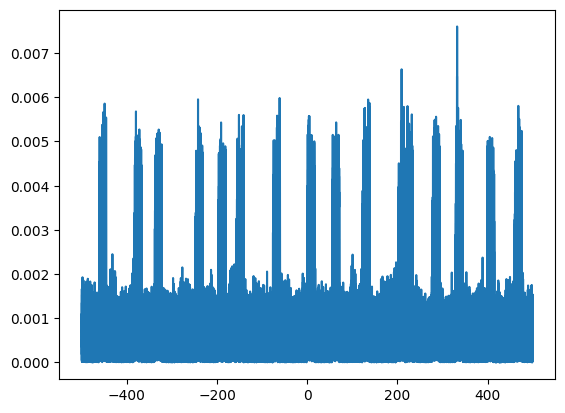

In [42]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.fft import fft, fftfreq

# Raw list of complex numbers where the complex part ends in "i".
raw_data: pd.DataFrame = pd.read_csv("data/csv/ZBW_SNR30.csv", sep=",", header=None, dtype=str)

# Map the raw data into a numpy array of complex numbers. The "i" in each row
# must be replaced with "j" because Python uses the engineering convention for
# representing complex numbers.
data: np.ndarray[complex] = (raw_data
                             .map(lambda row: np.csingle(row.replace('i', 'j')))
                             .values)

# The sample rate in Hz.
SAMPLE_RATE: int = 1000
# Number of samples in normalized_tone
N = len(data)

yf = fft(data)
xf = fftfreq(N, 1 / SAMPLE_RATE)

plt.plot(xf, np.abs(yf))
plt.show()
